Predicting wine type: Here I use Recursive Feature Elimination method for Feature selection and Bayesian search for searching method.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
white_wine=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')
red_wine=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
print(red_wine.shape, white_wine.shape)

(1599, 12) (4898, 12)


Merge two wine datasets

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>],
       [<AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>],
       [<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>,
        <AxesSubplot:title={'center':'wine_type'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

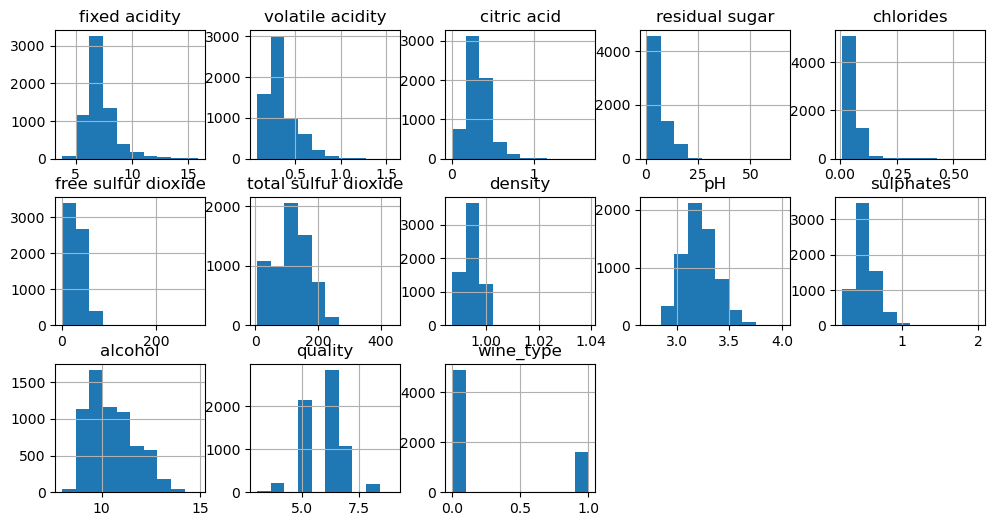

In [43]:
white_wine["wine_type"]=0
red_wine["wine_type"]=1
total_wine=pd.concat([white_wine, red_wine])
total_wine.hist(figsize=(12,6),layout=(3,5))

As it is seen above most of features are right-skewed. I transform the data to log to bring the destribution of data closeer to normal.

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>],
       [<AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>],
       [<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>,
        <AxesSubplot:title={'center':'wine_type'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

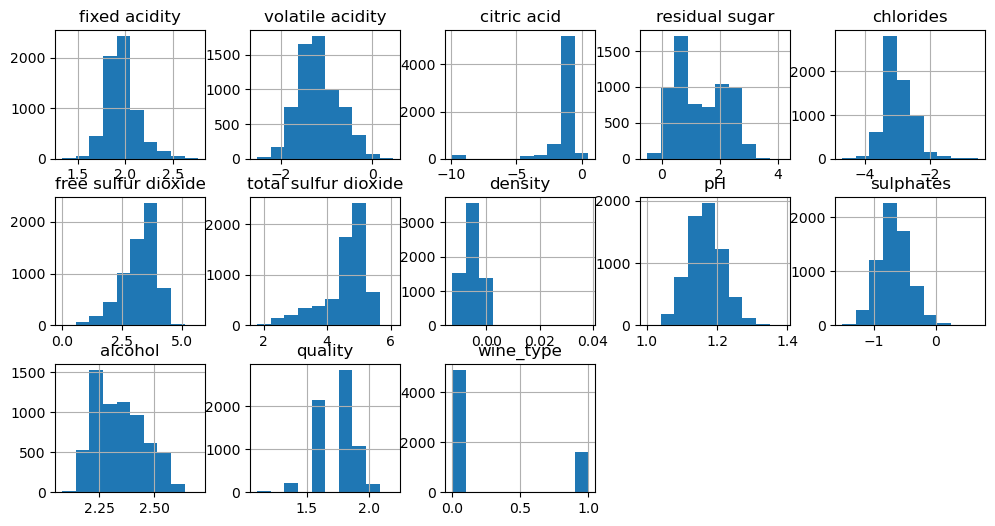

In [44]:
total_wine_t=np.log((total_wine[total_wine.columns[:-1]])+0.00005)
total_wine_t["wine_type"]=total_wine["wine_type"]
total_wine_t.hist(figsize=(12,6),layout=(3,5))

Plot pie chart to see how many red and white wines are there in the data set

([<matplotlib.patches.Wedge at 0x7fa2adba8eb0>,
 [Text(-0.7872560039826877, 0.7682629655223598, '0'),
  Text(0.7872559680177021, -0.7682630023764719, '1')],
 [Text(-0.4294123658087387, 0.41905252664855985, '75.39'),
  Text(0.42941234619147384, -0.41905254675080283, '24.61')])

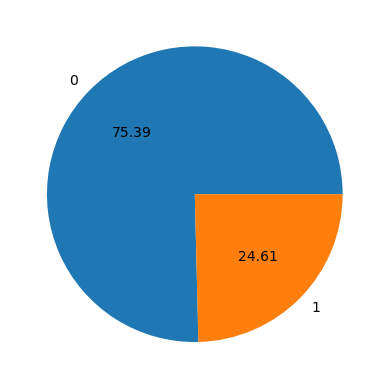

In [45]:
plt.pie(total_wine_t['wine_type'].value_counts(), labels=total_wine_t['wine_type'].unique(), autopct='%.2f')

In [46]:
total_wine_t.index=range(len(total_wine_t))

Split data

In [47]:
from sklearn.model_selection import train_test_split
x, y=total_wine_t[total_wine_t.columns[:-1]], total_wine_t[total_wine_t.columns[-1]]
x=np.array(x)
y=np.array(y)
X_train,X_test,y_train,y_test=train_test_split(x,y, test_size=0.3,shuffle=True, random_state=42,stratify=y) 

Create pipelines to use in nested cross validation

In [48]:
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as Xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier as LighGB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skopt import BayesSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

# initiakising classifiers

m1 = LogisticRegression(multi_class='multinomial',
                          solver='newton-cg',
                          random_state=1)
m2 = AdaBoostClassifier(random_state=1)
m3 = DecisionTreeClassifier(random_state=1)
m4 = LighGB(random_state=1)
m5 = RandomForestClassifier(random_state=1)

# Building the pipelines
pipe1 = Pipeline([('rfe', RFE(estimator=m1)),
                  ('m1', m1)])

pipe2 = Pipeline([('rfe', RFE(estimator=m2)),
                  ('m2', m2)])
                
pipe3=Pipeline([('rfe', RFE(estimator=m3)),
                  ('m3', m3)])

pipe4 = Pipeline([('rfe', RFE(estimator=m4)),
                  ('m4', m4)])
pipe5 = Pipeline([('rfe', RFE(estimator=m5)),
                  ('m5', m5)])



# Setting up the parameter grids
par1 = [{"rfe__n_features_to_select": [4,6,8,10], 'm1__penalty': ['l2'],
                'm1__C': np.power(10., np.arange(-4, 4))}]

par2 = [{"rfe__n_features_to_select": [4,6,8,10],"m2__n_estimators":[50,100,200,400,600], 
"m2__learning_rate": [1,3,5,12,16,20]}]

par3 = [{ "rfe__n_features_to_select": [4,6,8,10], "m3__criterion": ["gini", "entropy"],
"m3__splitter": ["best", "random"], "m3__max_depth": [None, 5,7,12,20]}]

par4 = [{"rfe__n_features_to_select": [4,5,6,7,8,9], 
"m4__max_depth": [-1,5,8], "m4__n_estimators": [100,300,500,30,700],
"m4__learning_rate": [1,2,4], "m4__subsample_for_bin":[500,1000,10000,200000]}]
par5 = [{"rfe__n_features_to_select": [4,6,8,10],  "m5__max_depth": [None,5,8,12,20],
              "m5__n_estimators" :[100,300,50,400,600],
              "m5__criterion": ["gini","entropy"],
              "m5__min_samples_split": [2,4,6],"m5__min_samples_leaf": [1,2,4,5]}]
 

Creat inner CV

In [49]:
pipe=[pipe1,pipe2,pipe3,pipe4,pipe5]
par_grid=[par1,par2,par3,par4,par5]
gcv_all=[]
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for i in range(len(pipe)):
    gcv = BayesSearchCV(estimator=pipe[i],
                        search_spaces=par_grid[i],
                        scoring='f1',
                        n_jobs=-1,
                        cv=inner_cv,
                        verbose=0,
                        refit=True)
    gcv_all.append(gcv)


Function for ploting learning curves

In [50]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Out CV + plotting learning curves 

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.

  LogisticRegression

       Best f1 score in inner CV 97.92%
        Best parameters in inner CV: OrderedDict([('m1__C', 100.0), ('m1__penalty', 'l2'), ('rfe__n_features_to_select', 8)])
       Best f1 score in outer CV 99.34%

       Best f1 score in inner CV 97.88%
        Best parameters in inner CV: OrderedDict([('m1__C', 1000.0), ('m1__penalty', 'l2'), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 98.90%

       Best f1 score in inner CV 98.02%
        Best parameters in inner CV: OrderedDict([('m1__C', 1000.0), ('m1__penalty', 'l2'), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 98.90%

       Best f1 score in inner CV 97.76%
        Best parameters in inner CV: OrderedDict([('m1__C', 100.0), ('m1__penalty', 'l2'), ('rfe__n_features_to_select', 8)])
       Best f1 score in o

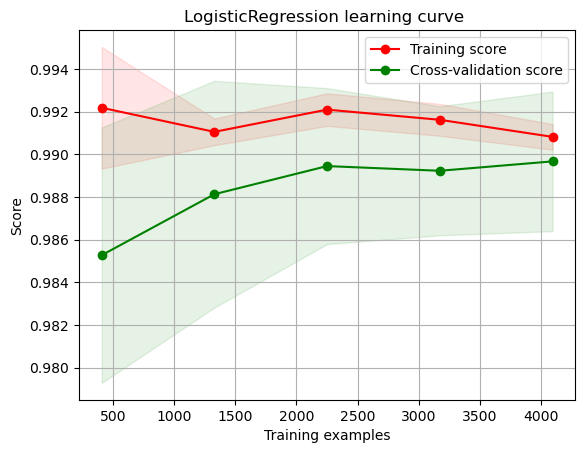

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.

  AdaBoostClassifier

       Best f1 score in inner CV 98.66%
        Best parameters in inner CV: OrderedDict([('m2__learning_rate', 1), ('m2__n_estimators', 50), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 99.56%

       Best f1 score in inner CV 98.86%
        Best parameters in inner CV: OrderedDict([('m2__learning_rate', 1), ('m2__n_estimators', 100), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 99.34%

       Best f1 score in inner CV 98.96%
        Best parameters in inner CV: OrderedDict([('m2__learning_rate', 1), ('m2__n_estimators', 100), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 99.12%

       Best f1 score in inner CV 98.80%
        Best parameters in inner CV: OrderedDict([('m2__learning_rate', 1), ('m2__n_estimators', 100), ('rfe__n_featu

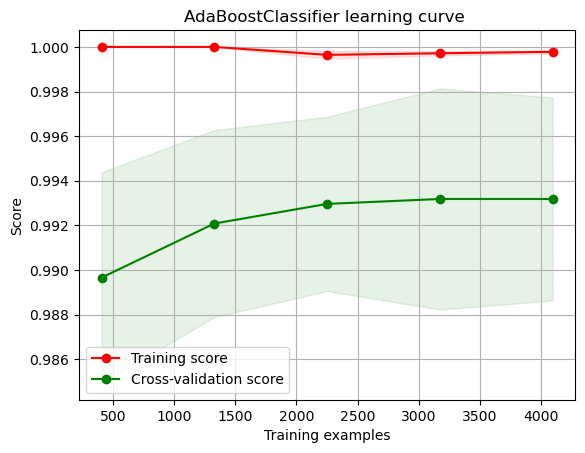

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.

  DecisionTreeClassifier

       Best f1 score in inner CV 96.71%
        Best parameters in inner CV: OrderedDict([('m3__criterion', 'entropy'), ('m3__max_depth', 7), ('m3__splitter', 'best'), ('rfe__n_features_to_select', 8)])
       Best f1 score in outer CV 98.46%

       Best f1 score in inner CV 97.15%
        Best parameters in inner CV: OrderedDict([('m3__criterion', 'entropy'), ('m3__max_depth', 7), ('m3__splitter', 'best'), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 98.02%

       Best f1 score in inner CV 96.76%
        Best parameters in inner CV: OrderedDict([('m3__criterion', 'entropy'), ('m3__max_depth', 20), ('m3__splitter', 'best'), ('rfe__n_features_to_select', 6)])
       Best f1 score in outer CV 98.24%

       Best f1 score in inner CV 97.29%
        Best parameters in inner CV: O

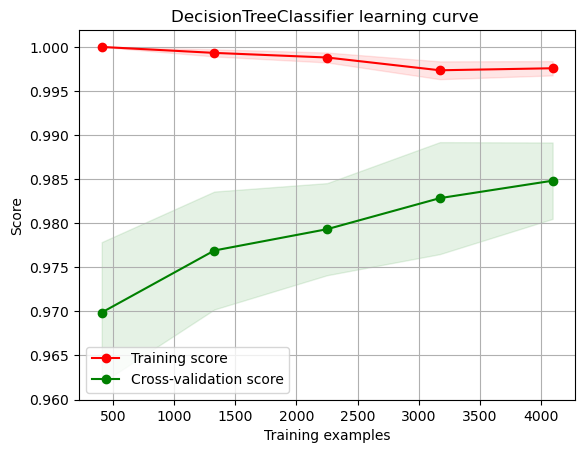

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.

  LighGB

       Best f1 score in inner CV 98.75%
        Best parameters in inner CV: OrderedDict([('m4__learning_rate', 1), ('m4__max_depth', 5), ('m4__n_estimators', 700), ('m4__subsample_for_bin', 200000), ('rfe__n_features_to_select', 9)])
       Best f1 score in outer CV 99.78%

       Best f1 score in inner CV 98.65%
        Best parameters in inner CV: OrderedDict([('m4__learning_rate', 1), ('m4__max_depth', -1), ('m4__n_estimators', 700), ('m4__subsample_for_bin', 200000), ('rfe__n_features_to_select', 9)])
       Best f1 score in outer CV 99.78%

       Best f1 score in inner CV 99.01%
        Best parameters in inner CV: OrderedDict([('m4__learning_rate', 1), ('m4__max_depth', 5), ('m4__n_estimators', 300), ('m4__subsample_for_bin', 1000), ('rfe__n_features_to_select', 9)])
       Best f1 score in outer CV 99.12%

 

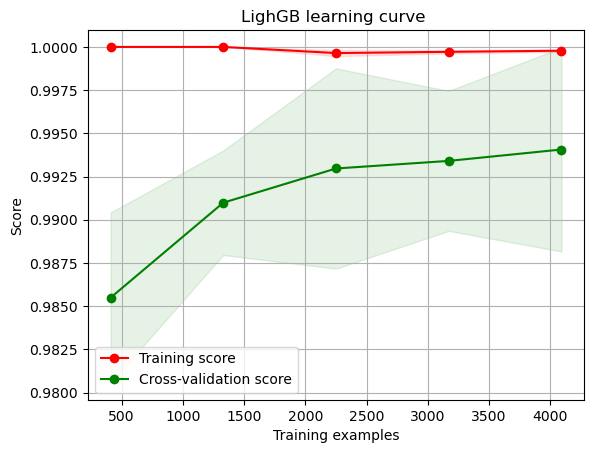

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.

  RandomForestClassifier

       Best f1 score in inner CV 98.70%
        Best parameters in inner CV: OrderedDict([('m5__criterion', 'entropy'), ('m5__max_depth', None), ('m5__min_samples_leaf', 4), ('m5__min_samples_split', 6), ('m5__n_estimators', 100), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 99.78%

       Best f1 score in inner CV 98.80%
        Best parameters in inner CV: OrderedDict([('m5__criterion', 'gini'), ('m5__max_depth', 12), ('m5__min_samples_leaf', 2), ('m5__min_samples_split', 4), ('m5__n_estimators', 300), ('rfe__n_features_to_select', 10)])
       Best f1 score in outer CV 99.56%

       Best f1 score in inner CV 98.90%
        Best parameters in inner CV: OrderedDict([('m5__criterion', 'entropy'), ('m5__max_depth', 20), ('m5__min_samples_leaf', 1), ('m5__min_samples_split', 4),

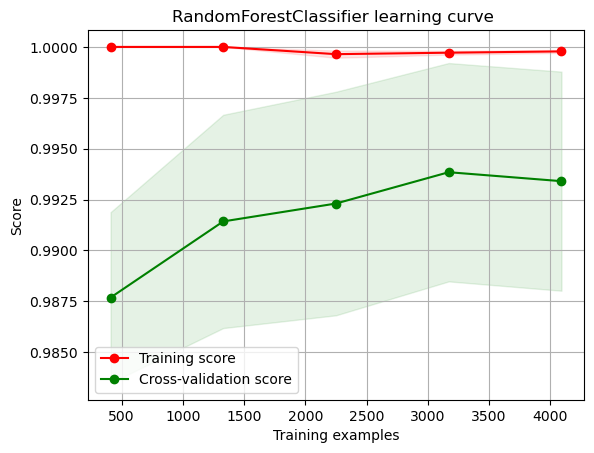

In [51]:
import warnings

warnings.simplefilter('ignore')



final_scores = []
final_mean_score=[]
final_std_score=[]

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
name=['LogisticRegression', 'AdaBoostClassifier','DecisionTreeClassifier'
,'LighGB', 'RandomForestClassifier'] 
count=0   
for gcv_out in gcv_all:  
    print(80*'_.')
    print('\n ', name[count] )  
    for train_idx, test_idx in outer_cv.split(X_train, y_train): 
        gcv_out.fit(X_train[train_idx], y_train[train_idx]) # run inner loop hyperparam tuning


        print('\n       Best f1 score in inner CV %.2f%%' % (gcv_out.best_score_ * 100))
        print('        Best parameters in inner CV:', gcv_out.best_params_)
        
    
        final_scores.append(gcv_out.best_estimator_.score(X_train[test_idx], y_train[test_idx]))
        print('       Best f1 score in outer CV %.2f%%' % (final_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        f1 score %.2f%% +/- %.2f' % 
                (np.mean(final_scores) * 100, np.std(final_scores) * 100))
    final_mean_score.append(np.mean(final_scores) * 100)
    final_std_score.append(np.std(final_scores) * 100)

    plot_learning_curve(estimator = gcv_out.best_estimator_,title = "{} learning curve ".format(name[count]),
                    X = X_train, y = y_train, cv = outer_cv)
    plt.show()

    count+=1

 

Comparing scores of different models

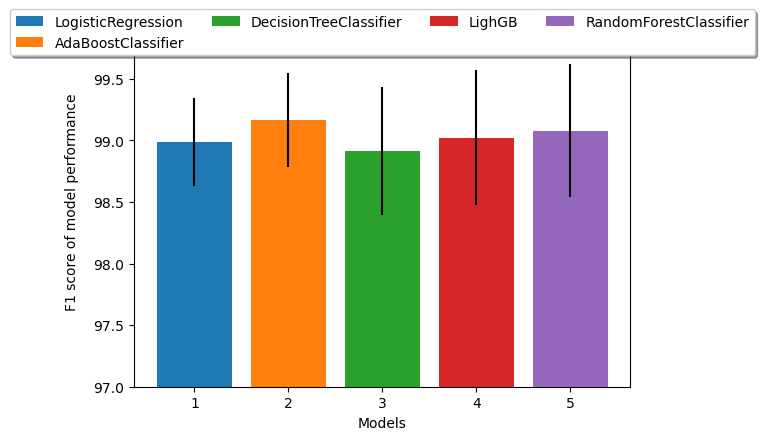

In [52]:
for i in range(1,1+len(final_mean_score)):
    plt.bar(x=i, height=final_mean_score[i-1], yerr=final_std_score[i-1] )
    plt.ylim(97,100)
    plt.legend(labels= name, 
    loc='upper center', bbox_to_anchor=(0.5, 1.04), fancybox=True, shadow=True, ncol=4)

    plt.xlabel('Models')
    plt.ylabel('F1 score of model performance')


plt.show()

In [53]:
def con(y_test,pred_rfc):
    labels = np.unique(y_test)
    a = confusion_matrix(y_test, pred_rfc)
    a = pd.DataFrame(a, index=("White-wine", "Red_wine"), columns=("White_wine", "Red_wine"))
    display(a)

Baes on above modeling results, the best model is model two (AdaBoostClassifier). So Now I repeat nested cross validation for the best model.

In [56]:
from sklearn.metrics import balanced_accuracy_score
gcv_model_select = BayesSearchCV(estimator=pipe2,
                                search_spaces=par2,
                                scoring='balanced_accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                n_iter=30,
                                refit=True)

for train_idx, test_idx in outer_cv.split(X_train, y_train): 
    gcv_model_select.fit(X_train[train_idx], y_train[train_idx]) # run inner loop hyperparam tuning
   

    print('\n       Best balanced accuracy score in inner CV %.2f%%' % (100*(gcv_model_select.best_score_)))
    print('        Best parameters in inner CV:', gcv_model_select.best_params_)
    print('       Best score in test data of outer CV %.2f%%' % (gcv_model_select.best_estimator_.score(X_train[test_idx], y_train[test_idx])*100))
        

m=gcv_model_select.best_estimator_.fit(X_train, y_train)
m=gcv_model_select.best_estimator_.fit(X_train, y_train)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)
print('test accuracy: %.2f%%' % (balanced_accuracy_score(y_test, m.predict(X_test))*100))
print('train accuracy: %.2f%%' % (balanced_accuracy_score(y_train, m.predict(X_train))*100))
con(m.predict(X_test),y_test)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

,White_wine,Red_wine
White-wine,1464,3
Red_wine,6,477


In [57]:
print('MCC is: %.2f%%' % (matthews_corrcoef(y_test, m.predict(X_test))*100))

MCC is: 98.76%


In [58]:
from sklearn.metrics import balanced_accuracy_score
print("Balaced accuracy is : %.2f%%" %(balanced_accuracy_score(y_test, m.
predict(X_test))*100))

Balaced accuracy is : 99.48%
